**Clustering tracks by audio features**

Group tracks into clusters (unsupervised) based on their audio features (tempo, key, loudness, danceability, etc.). Then characterize each cluster: what “type” of music tends to fall into each cluster? Are there clusters that map well to certain moods, energy levels, release years, etc?

In [1]:
# 1. Start a Spark session
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql import functions as F

drive.mount('/content/drive')

spark = SparkSession.builder \
    .appName("SpotifyAnalysis") \
    .getOrCreate()

# 2. Define the SILVER path
SILVER = "file:///content/drive/MyDrive/data/spotify/silver_parquet"

# 3. Read the Parquet dataset
spotify_df = spark.read.parquet(SILVER)

# 4. Inspect schema and a few rows
spotify_df.printSchema()
spotify_df.show(5, truncate=False)

# 6. Count total rows
print(f"Total records: {spotify_df.count()}")

#PREPROCESSING
# Keep only rows where track_genre does NOT match a numeric pattern
numeric_pattern = r"^[+-]?\d+(\.\d+)?([eE][+-]?\d+)?$"
spotify_df = spotify_df.filter(~F.col("track_genre").rlike(numeric_pattern))
spotify_df.select("track_genre").distinct().show(truncate=False)



Mounted at /content/drive
root
 |-- track_genre: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- popularity_z: double (nullable = true)
 |-- duration_ms_z: double (nullable = true)
 |-- danceability_z: double (nullable = true)
 |-- energy_

root
 |-- features: vector (nullable = true)
 |-- track_genre: string (nullable = true)



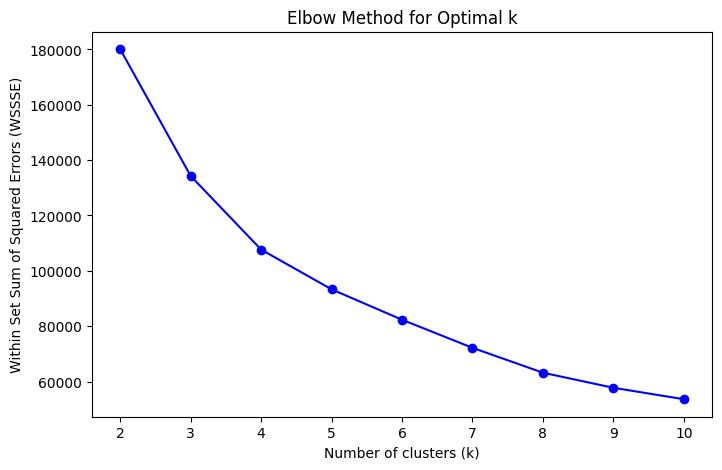

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Visualization
import matplotlib.pyplot as plt

# Select features for clustering
features = ["danceability_z", "energy_z", "tempo_z", "valence_z", "acousticness_z",
            "speechiness_z", "instrumentalness_z", "liveness_z", "loudness_z"]

df_clustering = spotify_df.select(*[f for f in features if f in spotify_df.columns])

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=df_clustering.columns, outputCol="features")
assembled_df = assembler.transform(df_clustering).select("features")

spotify_df = assembler.transform(spotify_df).select("features", "track_genre")
spotify_df.printSchema()
# Elbow method - compute cost for different k
cost = []
k_values = list(range(2, 11))  # try from 2 to 10 clusters

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(assembled_df)
    cost.append(model.summary.trainingCost)  # Within Set Sum of Squared Errors (WSSSE)

# 8. Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(k_values, cost, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method for Optimal k")
plt.show()


In [3]:

# Fit KMeans with k=4
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=1)
model = kmeans.fit(assembled_df)

# Add cluster assignments to the dataframe
clustered_df = model.transform(spotify_df)
clustered_df.printSchema()


root
 |-- features: vector (nullable = true)
 |-- track_genre: string (nullable = true)
 |-- cluster: integer (nullable = false)



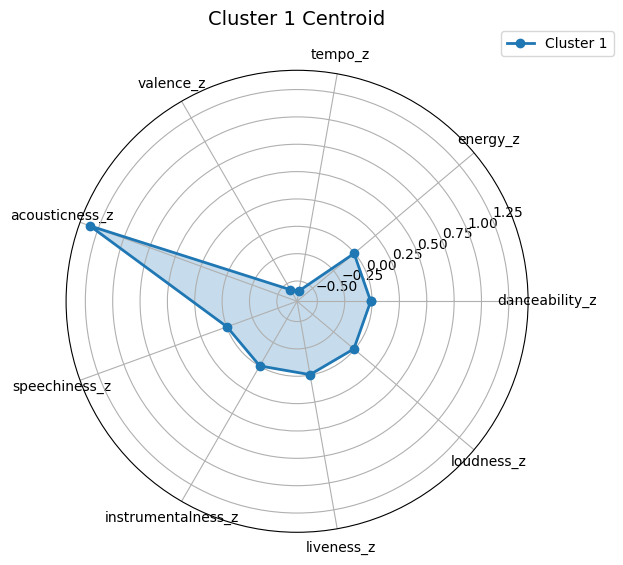

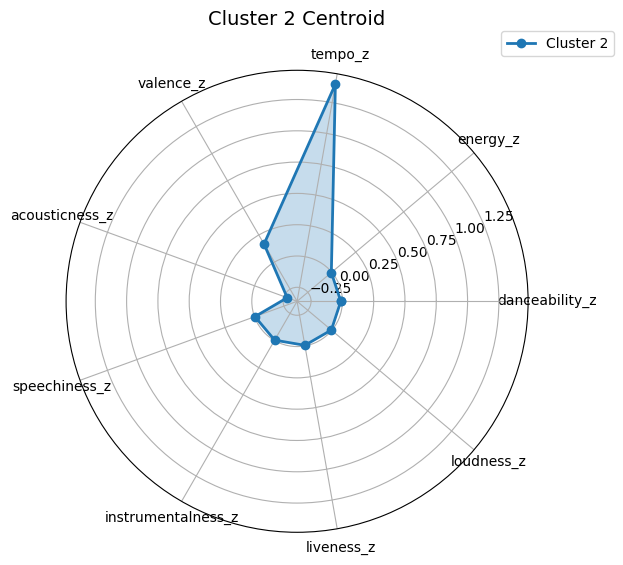

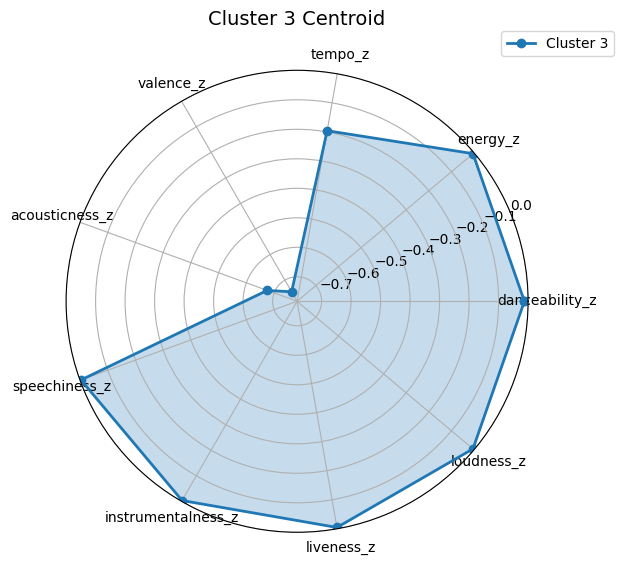

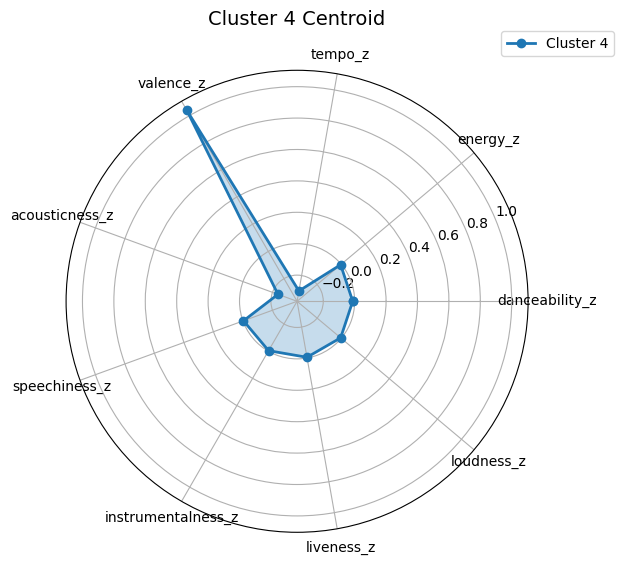

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Compute cluster centers with RDDs
# (cluster_id, feature_vector)
cluster_rdd = clustered_df.rdd.map(lambda row: (row.cluster, row.features.toArray()))

# Sum of vectors + counts per cluster
centroids_rdd = (cluster_rdd
                 .mapValues(lambda v: (v, 1))
                 .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                 .mapValues(lambda x: x[0] / x[1]))

# Collect cluster centers back to driver
centers = centroids_rdd.collect()
centers = sorted(centers, key=lambda x: x[0])  # sort by cluster id

# Convert to numpy arrays for plotting
centers_vectors = [c[1] for c in centers]

# Features for axes
labels = np.array(features)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Plot radar chart for each cluster
for cluster_id, values in enumerate(centers_vectors, start=1):
    values = list(values) + [values[0]]  # close the loop

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2, label=f"Cluster {cluster_id}")
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_title(f"Cluster {cluster_id} Centroid", size=14, y=1.08)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

    plt.show()


In [5]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Count number of tracks per cluster and genre
genre_counts = clustered_df.groupBy("cluster", "track_genre").count()

# Convert to Pandas for plotting
genre_pdf = genre_counts.toPandas()
print(genre_pdf)


     cluster    track_genre  count
0          1         latino    100
1          1    heavy-metal    261
2          1      punk-rock    235
3          2        british    183
4          3    alternative    125
..       ...            ...    ...
415        1        iranian    142
416        1            emo    297
417        2      reggaeton      9
418        0            edm      5
419        1  chicago-house      1

[420 rows x 3 columns]


/tmp/ipython-input-3644973177.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="count", y="track_genre", palette="viridis")


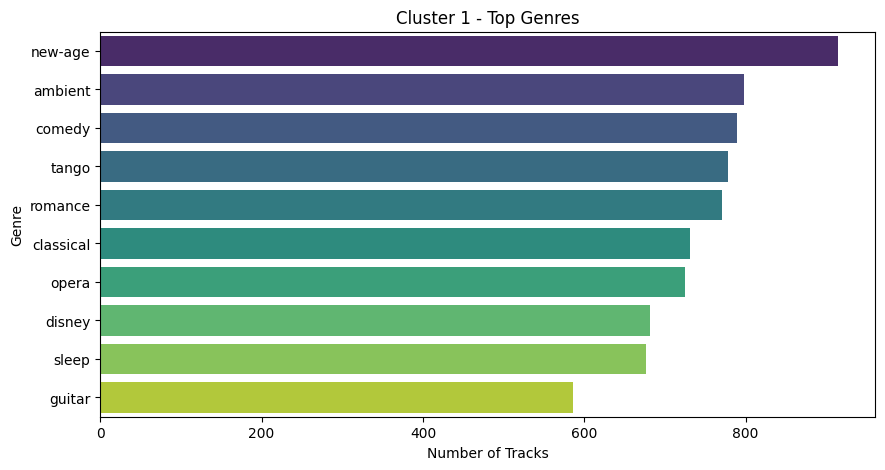

/tmp/ipython-input-3644973177.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="count", y="track_genre", palette="viridis")


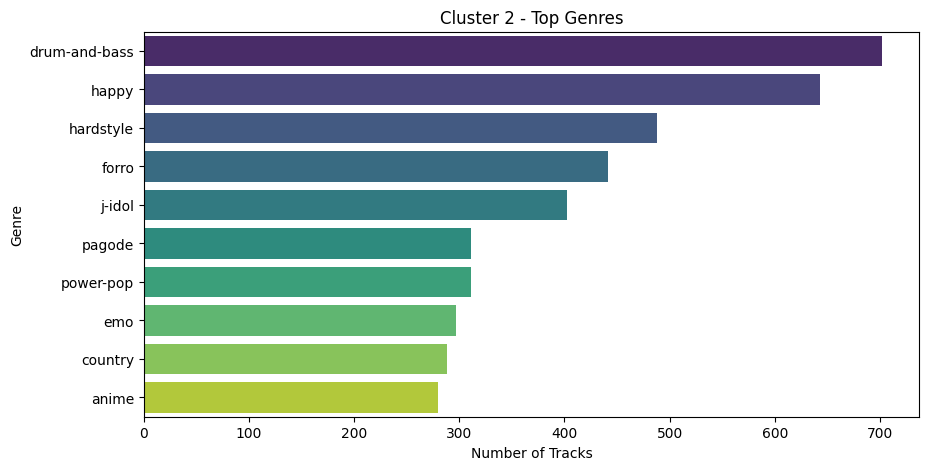

/tmp/ipython-input-3644973177.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="count", y="track_genre", palette="viridis")


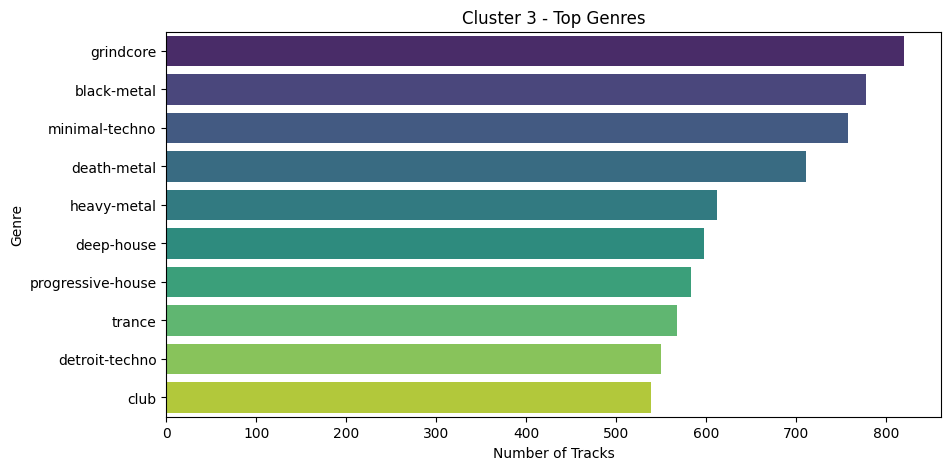

/tmp/ipython-input-3644973177.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="count", y="track_genre", palette="viridis")


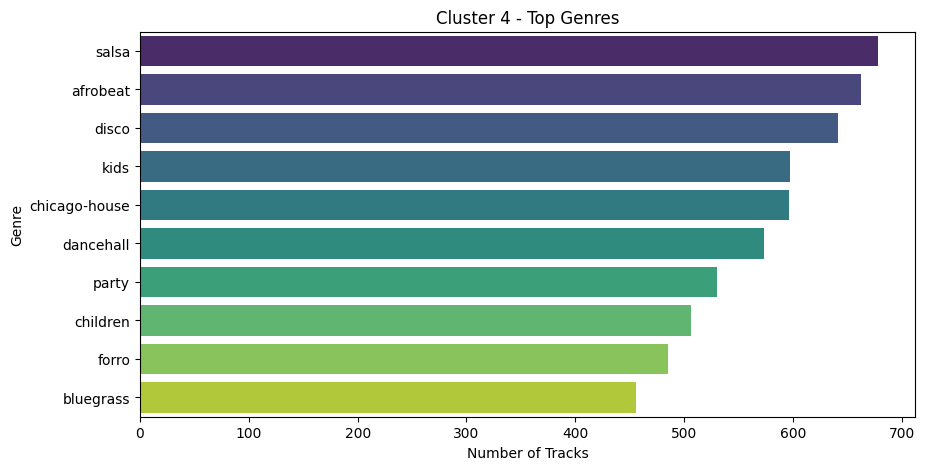

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution per cluster
clusters = sorted(genre_pdf["cluster"].unique())

for c in clusters:
    plt.figure(figsize=(10,5))
    subset = genre_pdf[genre_pdf["cluster"] == c].sort_values("count", ascending=False).head(10)  # top 10 genres
    sns.barplot(data=subset, x="count", y="track_genre", palette="viridis")
    plt.title(f"Cluster {c+1} - Top Genres")
    plt.xlabel("Number of Tracks")
    plt.ylabel("Genre")
    plt.show()


**Visualization of Clusters**


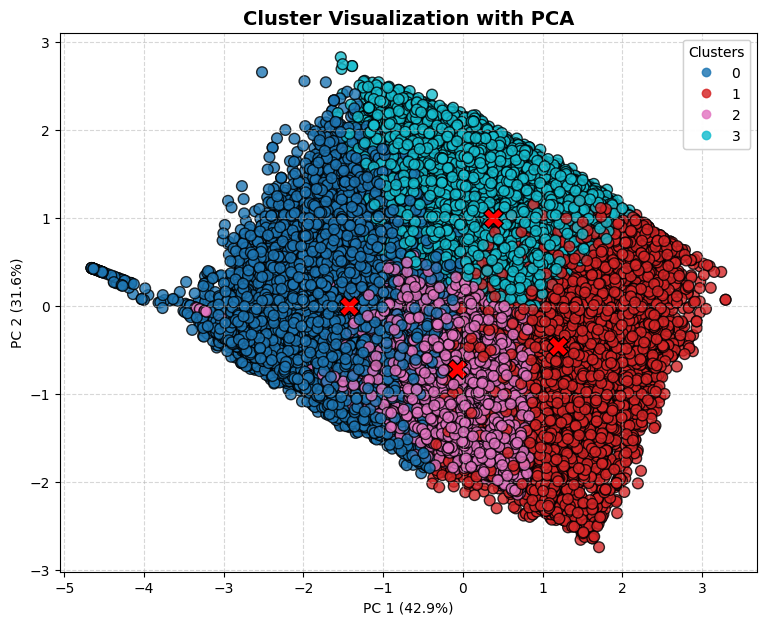

In [24]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert Spark DF to Pandas
pandas_df = clustered_df.toPandas()

# Extract features as a NumPy array
X = np.vstack(pandas_df["features"].values)

# Get cluster labels
labels = pandas_df["cluster"].values

# Reduce to 2D with PCA
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)

# Plot
plt.figure(figsize=(9,7))

# Scatter with larger points and edge color
scatter = plt.scatter(
    X_reduced[:,0],
    X_reduced[:,1],
    c=labels,
    cmap='tab10',
    alpha=0.8,
    s=60,                # point size
    edgecolors="k"        # black edges for clarity
)

# Add cluster centroids in PCA space
centroids = []
for cluster_id in np.unique(labels):
    cluster_points = X_reduced[labels == cluster_id]
    centroid = cluster_points.mean(axis=0)
    centroids.append(centroid)
    plt.scatter(*centroid, marker="X", s=200, c="red", edgecolors="k")

# Axis labels with explained variance
plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

# Title
plt.title("Cluster Visualization with PCA", fontsize=14, fontweight="bold")

# Legend with cluster IDs
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="best", frameon=True)
plt.gca().add_artist(legend1)

# Grid for readability
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()
